# Diffusion 2D

## Question 3

Let's break down the [problem statement](0.Kinetics_Module_Problems.ipynb) for question **3**:

### Declare simulation parameters

**note:**
- Distances are in micrometers
- Diffusion coefficient `DP` is in micrometers squared per second
- Times are in seconds

> A $7~\mathrm{\mu m}$ thick B-doped (p-type) Si wafer is annealed at $950~\mathrm{{}^\circ C}$ while in equilibrium with a gas containing P vapor (donor).

In [1]:
wafer_thickness  = 7.0

> The concentration of B in the wafer is $2\times 10^{17} / \mathrm{cm^3} = 2\times 10^5/\mathrm{\mu m^3}$.

In [2]:
CB = 2e5 # Bulk concentration of boron

> P diffusivity in this system at this condition is $D_P\approx 10^{-14}~\mathrm{cm^2/s} = 10^{-6}~\mathrm{\mu m^2/s}$.

In [3]:
DP = 1.0e-6 # Diffusion coefficient

> Assume that the concentration of P at the surface in this case is $10^{21}/\mathrm{cm^3} = 10^9/\mathrm{\mu m^3}$.

In [4]:
CPsurf = 1.0e9 # Surface concentration of phosphorus

### Import FiPy

[FiPy](https://www.ctcms.nist.gov/fipy) is an Open Source library for solving partial differential equations, written in Python. We'll use it for the rest of this example (aliased as `fp`).

In [5]:
import fipy as fp

### Define simulation domain

> Now part of the Si surface is covered by a mask in the manner shown below.

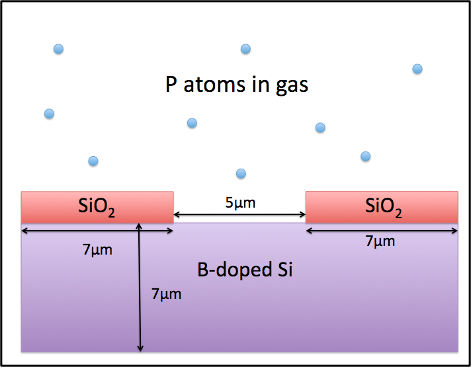

> How would you set up the domain of the simulation? What boundary conditions would you impose and where?

In [6]:
mask_width = 7.0 # width of SiO2 mask
aperture_width = 5.0 # width of gap in mask

Subdivide the 2D domain into a rectilinear grid, 190 by 70, of $100~\mathrm{nm} \times 100~\mathrm{nm}$ "cells".

In [7]:
device_width = 2 * mask_width + aperture_width # total width of device
nx = 190 # number of horizontal grid elements
ny = 70 # number of vertical grid elements

mesh = (fp.Grid2D(nx=nx, Lx=device_width, ny=ny, Ly=wafer_thickness)
        + [[-device_width/2.], [-wafer_thickness]])

**note:** we offset the mesh so that the origin is at the surface and on the centerline

### Define solution variable(s)

Declare memory storage for the P concentration across the cells of the mesh defined above. Initialize the concentration to zero and inform FiPy that the concentration will evolve in time.
$$C_P(x, y, t=0) = 0$$

In [8]:
CP = fp.CellVariable(mesh=mesh, name="$C_P / \mathrm{\mu m}^{-3}$",
                     value=0.0, hasOld=True)

### Define equation(s)

We want to solve [Fick's 2nd Law of diffusion](https://en.wikipedia.org/wiki/Fick%27s_laws_of_diffusion#Fick's_second_law), the 2D partial differential equation
$$\frac{\partial C_P}{\partial t} = \nabla\cdot\left(D_P \nabla C_P\right)$$

In [9]:
eq = fp.TransientTerm(var=CP) == fp.DiffusionTerm(coeff=DP, var=CP)

### Specify boundary condition(s)

\begin{align}
    C_P(x\not\in\mathrm{SiO_2}, y=0, t) &= C_{P,\text{surface}} \\
    \hat{n}\cdot\left.\nabla C_P(x, y, t)\right|_{x\in\mathrm{SiO_2}, y=0} &= 0 \\
    \hat{n}\cdot\left.\nabla C_P(x, y, t)\right|_{x=\pm 9.5~\mathrm{\mu m}} &= 0 \\
    \hat{n}\cdot\left.\nabla C_P(x, y, t)\right|_{y=-7~\mathrm{\mu m}} &= 0
\end{align}

Boundary conditions, or constraints, are applied at external faces that bound the cells where solutions are calculated. FiPy's boundary conditions are no-flux by default. We define a [Dirichlet condition](https://en.wikipedia.org/wiki/Dirichlet_boundary_condition) to fix the concentration at the exposed area of the wafer surface.

In [10]:
X, Y = mesh.faceCenters

mask_aperture = (mesh.facesTop
                 & (-aperture_width / 2 <= X)
                 & (X < aperture_width / 2))

CP.constrain(CPsurf, where=mask_aperture)

### Create viewer

`fp.Viewer()` is a general purpose routine that does its best to create a visualization using a variety of different plotting packages. Explicitly using the [`matplotlib`](https://matplotlib.org) package enables customization for more informative plots.

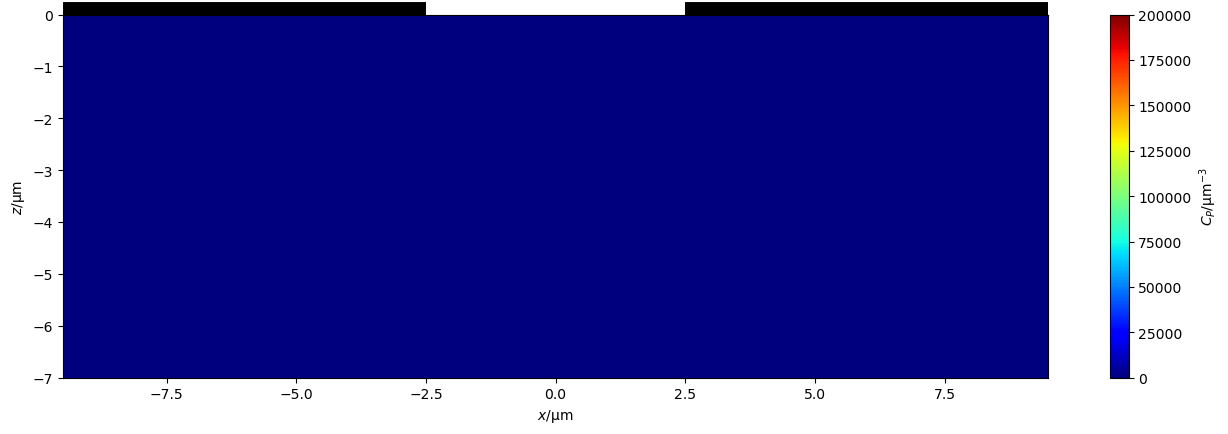

In [11]:
viewer = fp.MatplotlibViewer(vars=CP, datamin=0.0, datamax=CB)
viewer.axes.set_xlabel(r"$x / \mathrm{\mu m}$")
viewer.axes.set_ylabel(r"$z / \mathrm{\mu m}$")
# draw the mask
_ = viewer.axes.plot([-9.5, -2.5], [0.1, 0.1], [2.5, 9.5], [0.1, 0.1],
                     linewidth=10, color="black", clip_on=False, solid_capstyle="butt")

### Solve problem

> Simulate diffusion doping for the above situation [10 hours] and plot the concentration profile near the surface

In [12]:
dt = 20.0 # Time step
final_time = 36000 # total amount of time simulated

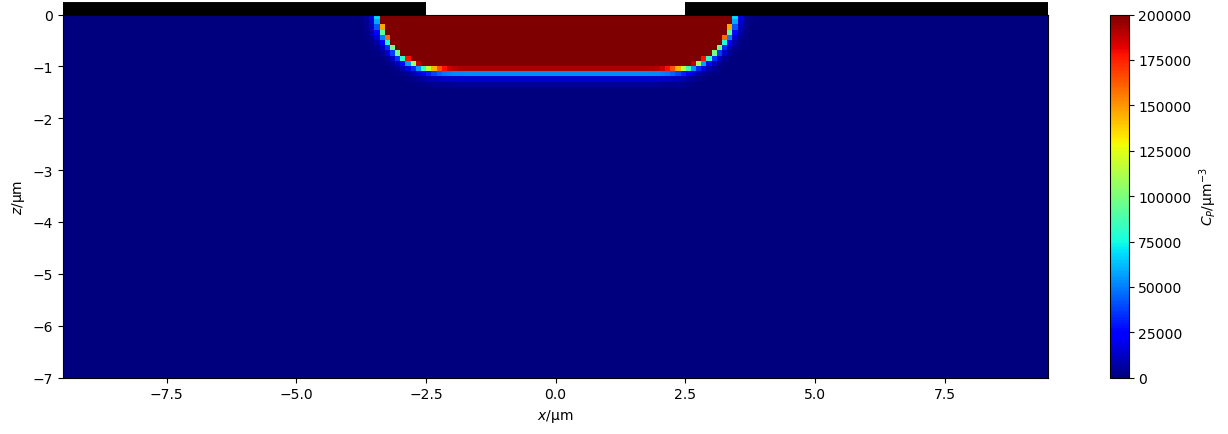

t = 36000.0 s


In [13]:
from petsc4py import PETSc

t = 0
while t <= final_time:
    t=t+dt
    CP.updateOld()
    eq.solve(dt=dt)
    if t % 1800 == 0:
        viewer.plot()
        print(f"t = {t} s")
        
    # FiPy 3.4.3 has a memory leak when using PETSc
    PETSc.garbage_cleanup()